In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
import pandas as pd
import io
import itertools
import random

In [12]:
human_chy = '../data/Homo_sapiens.GRCh38.dna_sm.chromosome.Y.fa'
motifs_input = '../data/human_motifs.fa'

In [2]:
# Crée les séquences de motifs à partir des probabilités contenus dans le fichier fasta. 
# Si la probabilité d'un nucléotide est supérieur au seuil, alors on considère qu'il fait parti du motif.
# Ensuite, un produit cartésien est fait pour créer toutes les séquences possibles et on les écrit dans un fichier.
def seq_ACGT(seuil_proba, motif,file):
    seq_ACGT = []
    for i in range(0,len(motif), 4):
        seq = motif[i:i+4]
        tmp = []
        if float(seq[0]) >= seuil_proba:
            tmp.append('A')
        if float(seq[1]) >= seuil_proba:
            tmp.append('C')
        if float(seq[2]) >= seuil_proba:
            tmp.append('G')
        if float(seq[3]) >= seuil_proba:
            tmp.append('T')
        seq_ACGT.append(tmp)
    file.write('\n'.join(map(''.join,list(itertools.product(*seq_ACGT)))))
    file.write('\n')

In [5]:
with open(motifs_input) as fasta_file:  
    identifiers = []
    seq_ADN = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        identifiers.append(seq_record.id)
        seq_ADN.append(seq_record.seq)
        lengths.append(len(seq_record.seq))
file = open('motifs_ATFG.txt',"w")

motifs = []
for i in range(0,len(seq_ADN)):
    seq = re.findall('\d.\d{6}',str(seq_ADN[i])) #Extraction des probabilités dans le fichier fasta
    seq_ACGT(0.25,seq, file)
file.close()

In [14]:
data_motifs = pd.read_csv('motifs_ATFG.txt', header = None)


In [5]:
data_motifs

,0
0,GAAATGTAGT
1,GAATTGTAGT
2,GAGATGTAGT
3,GAGTTGTAGT
4,GTCACGTGAC
...,...
45737693,CAGGGGTCACAGG
45737694,CAGGGGTCACGAG
45737695,CAGGGGTCACGGG
45737696,AAAGGTCAAAAGGTCA


In [15]:
#Pour notre ensemble, on choisit alétoirement 10000 motifs.
samples_nb = 10000
motifs_df = data_motifs.sample(n = samples_nb, random_state=42) 
motifs_df

,0
11049418,CCGTAGGGCAAGGATGAGGGGACACTGT
35623501,AAAAAAAACGCACAATGCTATCCTCATCCC
24917011,TCCAGACTCAGCGTAGCGGAGAGGCTCT
17330668,GCCTGGCGCAACGAAGAGTAGCGGGAGT
10216327,CCGTAACTCAAGGAAGCAGAGAGGCACT
...,...
16122049,GCCTAGCGCAGCGTAGAATAGAGAGTCT
31384786,TCGTAACGCAGCGTAGAGGGGCGGGCGT
13826265,GCCAAGGGCAGGGTTGCGTAGCGGCAGG
41468009,TGTGTTGGGACAGTGTGTTCTCGGTGG


Longueur minimum d"un motif :  17
Longueur maximal d"un motif :  30


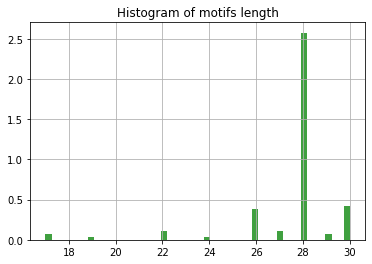

In [16]:
# the histogram of motifs length
x = [len(motifs_df.iat[i,0]) for i in range(0,len(motifs_df.index))]
min_len_motif = min(x)
max_len_motif = max(x)
print('Longueur minimum d"un motif : ', min(x))
print('Longueur maximal d"un motif : ', max(x))
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
plt.title('Histogram of motifs length')
plt.grid(True)
plt.show()

In [17]:
#Occurence of each length
len_motifs = pd.DataFrame(x)
len_motifs.value_counts(ascending=True)

19     1
24     1
17     2
29     2
22     3
27     3
26    10
30    11
28    67
dtype: int64

In [18]:
nucl_counts = dict()
for i in range(0,len(motifs_df.index)):
  for i in motifs_df.iat[i,0]:
    nucl_counts[i] = nucl_counts.get(i, 0) + 1
nucl_counts

{'C': 684, 'G': 855, 'T': 500, 'A': 709}

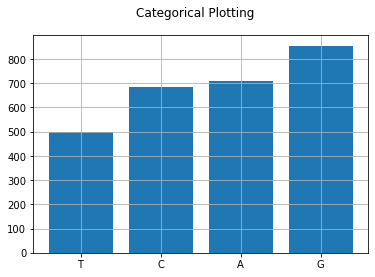

In [19]:
#Histogram of nucleotids
nucl_counts_sorted = { k : v for k, v in sorted(nucl_counts.items(), key=lambda item: item[1])}

names = list(nucl_counts_sorted.keys())
values = list(nucl_counts_sorted.values())

plt.bar(names, values)
plt.suptitle('Categorical Plotting')
plt.grid()
plt.show()

In [20]:
#dire si une séquence est ou non motif

def est_motif(motifs_df,seq,seuil):
    n,m = len(motifs_df.index),len(seq)
    for i in range(n):
        cur_dist = 0
        if len(motifs_df.iat[i,0]) == m:
            for j in range(m):
                if motifs_df.iloc[i,0][j] == 'A' and seq[j] != 'A':
                    cur_dist +=1
                    #print("incrémente 1")
                elif motifs_df.iloc[i,0][j] == 'T' and seq[j] != 'T':
                    cur_dist +=1
                    #print("incrémente 2")
                elif motifs_df.iloc[i,0][j] == 'G' and seq[j] != 'G':
                    cur_dist +=1
                    #print("incrémente 3")
                elif motifs_df.iloc[i,0][j] == 'C' and seq[j] != 'C':
                    cur_dist +=1
            if cur_dist <= int(seuil*m)+1:
                return True
    return False

In [21]:
est_motif(motifs_df, 'GGCCGGGCGC', 0.1)

False

On prend la séquence d'adn du chromosome Y et on le met en majuscule

In [22]:
with open(human_chy) as fasta_file:  # Will close handle cleanly
    identifiers = []
    seq_ADN = []
    lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seq_ADN.append(seq_record.seq)
        lengths.append(len(seq_record.seq))
seq_ADN = str(seq_ADN[0])
seq_ADN = seq_ADN.upper()

In [23]:
#On enlève les premiers termes égals à N
i = 0
while seq_ADN[i] == 'N': 
    i+=1
seq_ADN = seq_ADN[i:]

In [24]:
seq_ADN[0:4]

'GGCC'

A présent, on a notre séquence d'adn dans une string et on a enlevé tous les N du début

In [25]:
#Selection des non motifs : longueur aléatoire comprise entre les longueurs min et max des motifs
#En se basant sur la mesure de Hamming, on prend alors autant de non-motifs que de motifs

def random_selection(liste_motifs,seq_ADN,seuil):
    non_motif_list = []
    x = [len(liste_motifs.iat[i,0]) for i in range(0,len(liste_motifs.index))]
    min_len_motif = min(x)
    max_len_motif = max(x)
    bLen = False
    while bLen == False:
        for i in range(0,len(seq_ADN)):
            random_len = random.randint(min_len_motif,max_len_motif)
            if est_motif(liste_motifs,seq_ADN[i:i+random_len],seuil) == False and seq_ADN[i:i+random_len] not in non_motif_list: #On ajoute ce non-motif à la liste
                non_motif_list.append(seq_ADN[i:i+random_len])
            if len(non_motif_list) >= len(liste_motifs):
                bLen = True
                break

            
    return non_motif_list

    

In [26]:
non_motif_list = random_selection(motifs_df, seq_ADN, 0.2)

In [20]:
#Ecriture des non-motifs dans un fichier txt

for non_motif in non_motif_list:
    file.write(non_motif)
    file.write('\n')
file.close()

In [22]:
#Afin que les classificateurs puissent travailler sur les données, on transforme nos nucléotides en chiffres

def word_to_numbers(list_motifs):
    n = len(list_motifs)
    list_motifs_nombres = []
    for i in range(n):
        new = ''
        for j in list_motifs[i]:
            if j == 'A':
                #print('A')
                new += '1'
            elif j == 'C':
                #print('C')
                new += '2'
            elif j == 'G':
                #print('G')
                new += '3'
            elif j == 'T':
                #print('T')
                new += '4'
        list_motifs_nombres.append(new)
    return list_motifs_nombres

In [23]:
motifs = motifs_df[0].values.tolist()

In [24]:
motifs_numbers = word_to_numbers(motifs)
non_motifs_numbers = word_to_numbers(non_motif_list)

In [25]:
#Mise en place des labels de nos séquences : motif / non-motif

list_of_zeros = [0 for i in range(len(motifs))] #MOTIFS
list_of_ones = [1 for i in range(len(non_motif_list))]

motifs_numbers_df = pd.DataFrame(list(zip(motifs_numbers, list_of_zeros)),columns =['sequence', 'etiquette'])
#motifs_numbers_df

non_motifs_numbers_df = pd.DataFrame(list(zip(non_motifs_numbers, list_of_ones)),columns =['sequence', 'etiquette'])
#non_motifs_numbers_df

In [26]:
#Création du dataset final contenant 10000 motifs et 10000 non-motifs, le tout étiquetté
final_df = pd.concat([motifs_numbers_df, non_motifs_numbers_df])
final_df

,sequence,etiquette
0,2234133321133143133331212434,0
1,111111112321211432414224214222,0
2,4221312421323413233131332424,0
3,3224332321123113134132333134,0
4,2234112421133113213131332124,0
...,...,...
9995,41432111212,1
9996,1432111212134441221,1
9997,43211121213,1
9998,3211121213444,1


In [21]:
#to csv

final_df.to_csv('train.csv', index=False)